In [1]:
#import dask
#from dask.distributed import Client, LocalCluster
#cluster = LocalCluster(n_workers=8,threads_per_worker=1)
#client = Client(cluster)

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xmitgcm import llcreader
import zarr

In [4]:
model = llcreader.PleiadesLLC4320Model()
ds = model.get_dataset(varnames=['Eta','PhiBot'])

In [3]:
#Let's write the relevant atmospheric pressure to zarr
fp = np.memmap('/nobackup/dmenemen/forcing/ECMWF_operational/EOG_pres_tide_2011',
               dtype='>f4',mode='r',shape=(8760,1280,2560))

lon = np.cumsum(np.asarray([0] + [0.140625] * 2559))
lat = -89.8924 + np.cumsum(np.asarray([0, .1394, .14018, .14039, .1404695, .140496, 
                             .1405145, .1405275, .1405375, .1405455,
                             .140552, .1405575, .140562, .1405655,
                             .140568, .1405695] +  [.14057] * 1249 + 
                    [.1405695, .140568, .1405655, .140562,
                     .1405575, .140552, .1405455,.1405375,
                     .1405275, .1405145, .140496, .1404695,
                     .14039, .14018, .1394]))
lon[lon>180] = lon[lon>180]-360

t=0
newarray = fp[-2640+t,:,:]
newarray = np.expand_dims(newarray,axis=0)
time = np.expand_dims(np.asarray(ds.time.isel(time=t).values),0)
pres_xr = xr.DataArray(newarray, dims=['time','lat','lon'],coords=dict(lon=lon,lat=lat))#time=time,
surface_pressure = (pres_xr.roll(lon=200)).sel(lat=slice(-58,-26)).isel(lon=slice(88,455))
surface_pressure.chunk({'lat':-1}).to_dataset(name='Pressure').to_zarr('atm_pressure.zarr')
for t in range(1,2000):
    newarray = fp[-2640+t,:,:]
    newarray = np.expand_dims(newarray,axis=0)
    time = np.expand_dims(np.asarray(ds.time.isel(time=t).values),0)
    pres_xr = xr.DataArray(newarray, dims=['time','lat','lon'],coords=dict(lon=lon,lat=lat))#time=time,
    surface_pressure = (pres_xr.roll(lon=200)).sel(lat=slice(-58,-26)).isel(lon=slice(88,455))
    surface_pressure.chunk({'lat':-1}).to_dataset(name='Pressure').to_zarr('atm_pressure.zarr',append_dim='time')

/nobackup/csjone15/miniconda3/envs/pangeo-0ac8885/lib/python3.8/site-packages/xarray/core/dataarray.py:3267: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(


In [3]:
surface_pressure=xr.open_zarr('atm_pressure.zarr').Pressure

In [4]:
surface_pressure#.isel(lat=100,lon=100,time=slice(0,200)).plot()

<xarray.DataArray 'Pressure' (time: 2000, lat: 228, lon: 367)>
dask.array<open_dataset-1e6c709240832141384cd62c74a7093bPressure, shape=(2000, 228, 367), dtype=float32, chunksize=(1, 228, 367), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -57.99 -57.84 -57.7 -57.56 ... -26.36 -26.22 -26.08
  * lon      (lon) float64 -15.75 -15.61 -15.47 -15.33 ... 35.44 35.58 35.72
Dimensions without coordinates: time

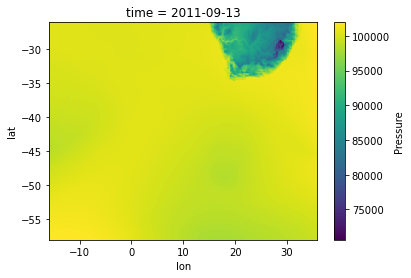

In [7]:
#surface_pressure = (pres_xr.Pressure.roll(lon=200)).sel(lat=slice(-58,-26)).isel(lon=slice(88,455))
surface_pressure.isel(time=1).plot()

In [5]:
import xesmf as xe

In [6]:
face_lat = ds.Eta.isel(time=0,face=1,j=slice(0,2160),i=slice(1080,1080+2160)).YC.mean('i')
face_lon = ds.Eta.isel(time=0,face=1,j=slice(0,2160),i=slice(1080,1080+2160)).XC.mean('j')

In [7]:
ds_out = xr.Dataset({'lat': (['lat'], face_lat.values),
                     'lon': (['lon'], face_lon.values),
                    }
                   )

In [8]:
surface_pressure_rename = surface_pressure.rename({'lon':'longitude','lat':'latitude'})

In [9]:
ds_out_rename = ds_out.rename({'lon':'longitude','lat':'latitude'})

In [10]:
regridder = xe.Regridder(surface_pressure_rename.T.isel(time=0), ds_out_rename, 'bilinear')

/nobackup/csjone15/miniconda3/envs/pangeo-0ac8885/lib/python3.8/site-packages/dask/array/core.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


In [11]:
dr_out = regridder(surface_pressure_rename.isel(time=[0]).load())
dr_ij = dr_out.drop_vars(['latitude','longitude']).rename({'latitude':'j','longitude':'i'})
dr_ij.chunk({'i':-1,'j':-1}).to_dataset(name='Pressure').to_zarr('regridded_pressure.zarr')

for t in range(1,2000):
    dr_out = regridder(surface_pressure_rename.isel(time=[t]).load())
    dr_ij = dr_out.drop_vars(['latitude','longitude']).rename({'latitude':'j','longitude':'i'})
    dr_ij.chunk({'i':-1,'j':-1}).to_dataset(name='Pressure').to_zarr('regridded_pressure.zarr', append_dim='time')

In [10]:
#for t in range(1201,1800):
#    dr_out = regridder(surface_pressure_rename.isel(time=[t]).load())
#    dr_ij = dr_out.drop_vars(['latitude','longitude']).rename({'latitude':'j','longitude':'i'})
#    dr_ij.chunk({'i':-1,'j':-1}).to_dataset(name='Pressure').to_zarr('regridded_pressure.zarr', append_dim='time')

In [5]:
dr_ij = xr.open_zarr('regridded_pressure.zarr').Pressure

In [4]:
mean_phibot = xr.open_zarr('mean_phibot.zarr')
phibot_mr = ds.PhiBot.isel(face=1,j=slice(0,2160),i=slice(1080,1080+2160)) - mean_phibot.PhiBot

In [5]:
mean_eta = xr.open_zarr('mean_eta.zarr')
eta_mr = ds.Eta.isel(face=1,j=slice(0,2160),i=slice(1080,1080+2160)
                          ) - mean_eta.Eta

In [6]:
mean_pres = xr.open_zarr('mean_atm_pressure.zarr')
pres_mr = dr_ij - mean_pres.pressure.load()
#pres_mr = pres_mr#.assign_coords(time=eta_mr.time.isel(time=slice(2640-2640,2640-1440)))

In [7]:
dr_ij#.isel(i=1000,j=1000).isel(time=slice(0,200)).plot()

<xarray.DataArray 'Pressure' (time: 2000, j: 2160, i: 2160)>
dask.array<open_dataset-6fe004ad72a38cc670e3d7a86c4e153bPressure, shape=(2000, 2160, 2160), dtype=float32, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>
Dimensions without coordinates: time, j, i
Attributes:
    regrid_method:  bilinear

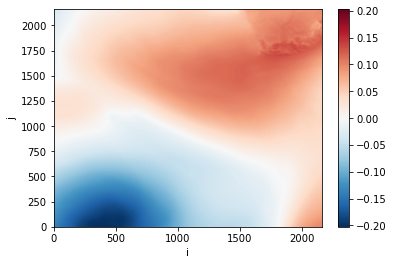

In [8]:
(pres_mr.isel(time=-1)/9.81/1027.5).plot()

In [31]:
eta_mr.isel(time=slice(2640-2640,2640-841))

<xarray.DataArray 'Eta' (time: 1799, j: 2160, i: 2160)>
dask.array<getitem, shape=(1799, 2160, 2160), dtype=float32, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>
Coordinates: (12/13)
    face     int64 1
  * i        (i) int64 1080 1081 1082 1083 1084 ... 3235 3236 3237 3238 3239
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 2153 2154 2155 2156 2157 2158 2159
    niter    (time) int64 ...
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-11-26T22:00:00
    CS       (j, i) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    ...       ...
    Depth    (j, i) float32 4.579e+03 4.611e+03 4.648e+03 ... 0.0 0.0 0.0
    dxF      (j, i) float32 1.261e+03 1.261e+03 1.261e+03 ... 2.07e+03 2.07e+03
    dyF      (j, i) float32 1.231e+03 1.231e+03 ... 1.903e+03 1.903e+03
    rA       (j, i) float32 1.553e+06 1.553e+06 ... 3.939e+06 3.939e+06
    XC       (j, i) float32 -15.49 -15.47 -15.45 -15.43 ... 29.45 29.47 29.49
    YC       (j, i) float32 -57.0 -57.0 -57.0 -57.0 ... -26.66 -26.66 -26.66

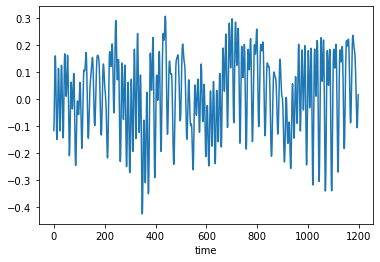

In [11]:
(pres_mr.isel(i=1000,j=1000)/9.81/1027.5).plot()

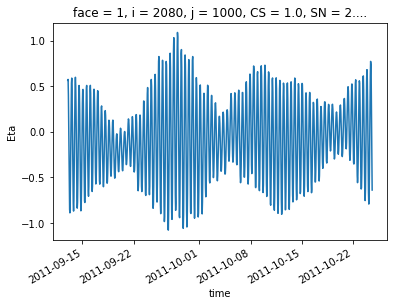

In [16]:
eta_mr.isel(i=1000,j=1000,time=slice(0,1000)).plot()

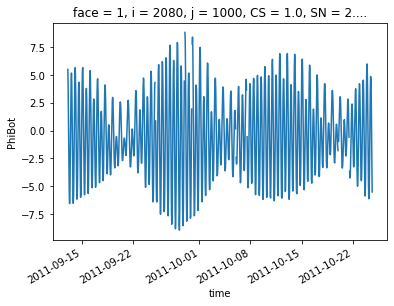

In [19]:
phibot_mr.isel(i=1000,j=1000,time=slice(0,1000)).where(phibot_mr.isel(i=1000,j=1000,time=slice(0,1000))>-100).plot()

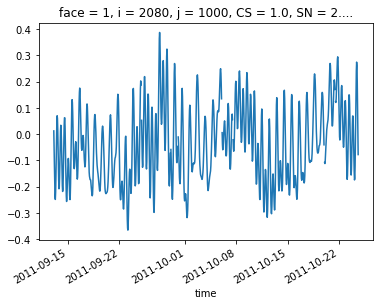

In [20]:
(eta_mr.isel(i=1000,j=1000,time=slice(0,1000))
 -phibot_mr.isel(i=1000,j=1000,time=slice(0,1000)).where(phibot_mr.isel(i=1000,j=1000,time=slice(0,1000))>-100
                                                        )/9.81).plot()

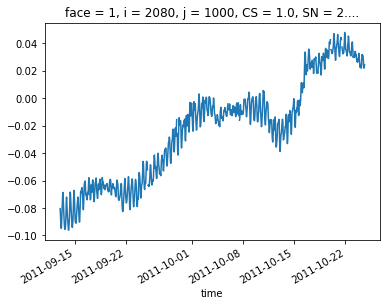

In [ ]:
(eta_mr.isel(i=1000,j=1000,time=slice(0,1000))+pres_mr.isel(i=1000,j=1000,time=slice(0,1000))/9.81/1027.5
 -phibot_mr.isel(i=1000,j=1000,time=slice(0,1000)).where(phibot_mr.isel(i=1000,j=1000,time=slice(0,1000))>-100
                                                        )/9.81).plot()

In [27]:
eta_mr.isel(time=slice(2640-2640,2640-841))

<xarray.DataArray 'Eta' (time: 1799, j: 2160, i: 2160)>
dask.array<getitem, shape=(1799, 2160, 2160), dtype=float32, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>
Coordinates: (12/13)
    face     int64 1
  * i        (i) int64 1080 1081 1082 1083 1084 ... 3235 3236 3237 3238 3239
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 2153 2154 2155 2156 2157 2158 2159
    niter    (time) int64 ...
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-11-26T22:00:00
    CS       (j, i) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    ...       ...
    Depth    (j, i) float32 4.579e+03 4.611e+03 4.648e+03 ... 0.0 0.0 0.0
    dxF      (j, i) float32 1.261e+03 1.261e+03 1.261e+03 ... 2.07e+03 2.07e+03
    dyF      (j, i) float32 1.231e+03 1.231e+03 ... 1.903e+03 1.903e+03
    rA       (j, i) float32 1.553e+06 1.553e+06 ... 3.939e+06 3.939e+06
    XC       (j, i) float32 -15.49 -15.47 -15.45 -15.43 ... 29.45 29.47 29.49
    YC       (j, i) float32 -57.0 -57.0 -57.0 -57.0 ... -26.66 -26.66 -26.66

In [28]:
pres_mr#.isel(time=slice(2640-2640,2640-721))

<xarray.DataArray (time: 1198, j: 2160, i: 2160)>
dask.array<sub, shape=(1198, 2160, 2160), dtype=float64, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>
Dimensions without coordinates: time, j, i

In [6]:
steric_est = (ds.Eta.isel(face=1,j=slice(0,2160),i=slice(1080,1080+2160)
                          ).isel(time=slice(2640-2640,2640-721))
              +dr_ij.isel(time=slice(2640-2640,2640-721))/9.81/1027.5
 -ds.PhiBot.isel(face=1,j=slice(0,2160),i=slice(1080,1080+2160)).isel(time=slice(2640-2640,2640-721))/9.81)

In [11]:
steric_replace_missing = steric_est
steric_est_chosen_loc = steric_est.isel(j=1000,i=1000)    
steric_replace_missing = steric_replace_missing.where(steric_est_chosen_loc<-20)
steric_replace_missing = steric_replace_missing.ffill('time')

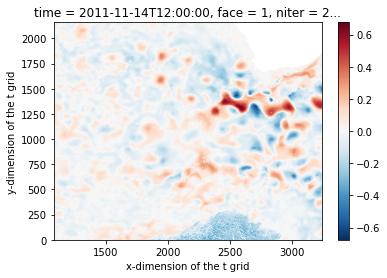

In [10]:
steric_replace_missing.isel(time=1500).plot()

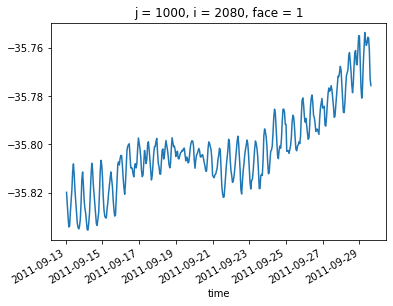

In [14]:
steric_replace_missing.isel(j=1000,i=1000,time=slice(0,400)).plot()

In [15]:
steric_replace_missing.to_dataset(name='steric').to_zarr('steric_inc_mean.zarr')

In [16]:
steric_out = xr.open_zarr('steric_inc_mean.zarr')

In [17]:
steric_out.steric.isel(time=1700).time#.isel(time=1500).plot()

<xarray.DataArray 'time' ()>
array('2011-11-22T20:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    face     int64 ...
    niter    int64 dask.array<chunksize=(), meta=np.ndarray>
    time     datetime64[ns] 2011-11-22T20:00:00

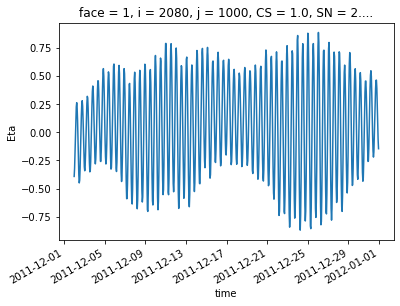

In [192]:
eta_mr.isel(time=slice(2640-720,2640)).isel(i=1000,j=1000).plot()

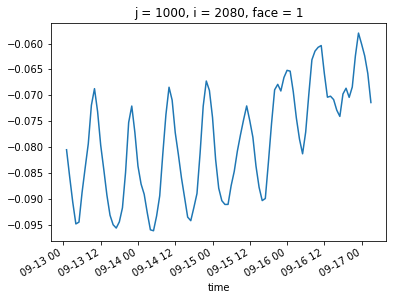

In [15]:
steric_replace_missing.isel(i=1000,j=1000,time=slice(0,100)).plot()

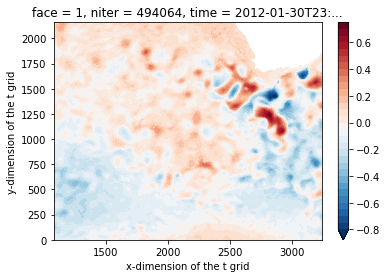

In [149]:
(eta_mr.isel(time=2639+720)+pres_mr.isel(time=-1)/9.81/1027.5
 -phibot_mr.isel(time=2639+720)/9.81).plot(levels=np.arange(-0.8,0.8,0.05))
figure=plt.gcf()
figure.savefig('jinbos_steric.png')

In [46]:
steric_out.steric.isel(time=1700)

<xarray.DataArray 'time' ()>
array('2011-11-22T20:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    face     int64 ...
    niter    int64 dask.array<chunksize=(), meta=np.ndarray>
    time     datetime64[ns] 2011-11-22T20:00:00

In [47]:
indir = '/nobackup/jwang23/llc4320_stripe/global.dynamic.height.shuiming/'
import scipy.io
mat = scipy.io.loadmat(indir +'dh_grids_fname.mat')
dyn = xr.open_dataset('/nobackup/jwang23/llc4320_stripe/global.dynamic.height.shuiming/dh/2011_11_22_20.h5')

In [48]:
lat = mat.get('lat_eta')
lon = mat.get('lon_eta')
lon[lon>180]=lon[lon>180]-360
steric_height = dyn.assign_coords({"phony_dim_0": np.squeeze(lat),"phony_dim_1": np.squeeze(lon) }
                                 ).rename({"phony_dim_0": "lat","phony_dim_1": "lon" })
steric_height = steric_height.roll(lon=1000,roll_coords=True)

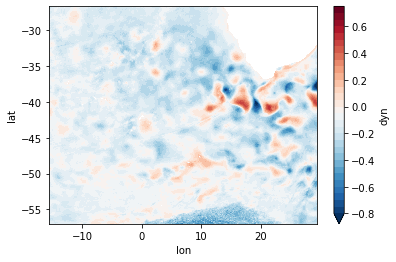

In [49]:
steric_height.dyn.isel(lon=slice(256,2416),lat=slice(1440,3600)).plot(levels=np.arange(-0.8,0.8,0.05))

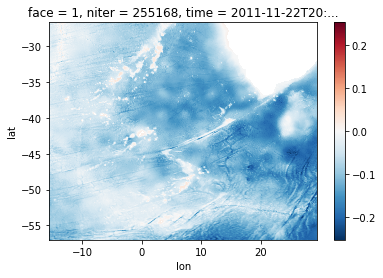

In [54]:
(steric_height.dyn.isel(lon=slice(256,2416),lat=slice(1440,3600)
                      )-steric_out.steric.isel(time=1700).drop_vars(['i','j']).rename({'i':'lon','j':'lat'})).plot()

In [52]:
steric_out.steric.drop_vars(['i','j'])

<xarray.DataArray 'steric' (time: 1799, j: 2160, i: 2160)>
dask.array<open_dataset-824b79a0f10989fb589330019e3aa4ccsteric, shape=(1799, 2160, 2160), dtype=float64, chunksize=(2, 2160, 2160), chunktype=numpy.ndarray>
Coordinates:
    face     int64 ...
    niter    (time) int64 dask.array<chunksize=(1799,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-11-26T22:00:00
Dimensions without coordinates: j, i

In [32]:
steric_height.dyn.isel(lon=slice(256,2416),lat=slice(1440,3600))

<xarray.DataArray 'dyn' (lat: 2160, lon: 2160)>
array([[-0.18186188, -0.18226624, -0.18328094, ..., -0.15467072,
        -0.15368652, -0.15353394],
       [-0.18136978, -0.18413925, -0.1836052 , ..., -0.15380096,
        -0.15213013, -0.1522522 ],
       [-0.18307495, -0.18271255, -0.18525696, ..., -0.15280914,
        -0.15177917, -0.15135193],
       ...,
       [-0.09692764, -0.098032  , -0.09815216, ...,         nan,
                nan,         nan],
       [-0.0969944 , -0.09877586, -0.09839058, ...,         nan,
                nan,         nan],
       [-0.0925827 , -0.0962429 , -0.09780121, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -57.0 -56.99 -56.98 -56.97 ... -26.69 -26.68 -26.66
  * lon      (lon) float32 -15.49 -15.47 -15.45 -15.43 ... 29.45 29.47 29.49

In [92]:
phibot_mr.isel(time=2639+720).time

<xarray.DataArray 'time' ()>
array('2012-01-30T23:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    face     int64 1
    niter    int64 ...
    time     datetime64[ns] 2012-01-30T23:00:00

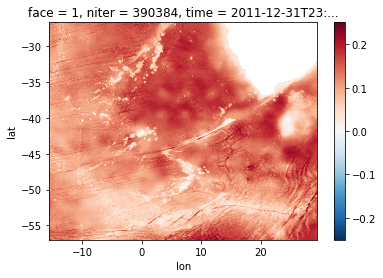

In [41]:
# last day of 2011
my_steric = (eta_mr.isel(time=2639)+pres_mr/9.81/1027.5
 -phibot_mr.isel(time=2639)/9.81).drop_vars(['i','j']).rename({'i':'lon','j':'lat'})
(my_steric - steric_height.dyn.isel(lon=slice(256,2416),lat=slice(1440,3600))).plot()

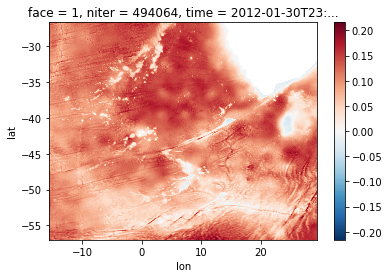

In [93]:
# last day of Jan 2012
my_steric = (eta_mr.isel(time=2639+720)+pres_mr/9.81/1027.5
 -phibot_mr.isel(time=2639+720)/9.81).drop_vars(['i','j']).rename({'i':'lon','j':'lat'})
(my_steric - steric_height.dyn.isel(lon=slice(256,2416),lat=slice(1440,3600))).plot()

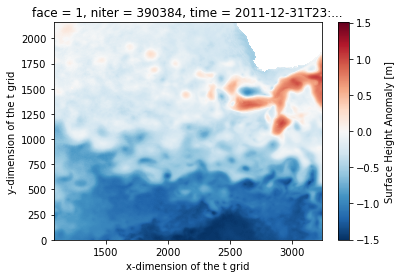

In [86]:
ds.Eta.isel(time=2639,face=1,j=slice(0,2160),i=slice(1080,1080+2160)).plot()

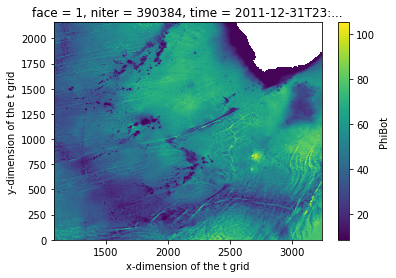

In [84]:
(ds.PhiBot.isel(time=2639,face=1,j=slice(0,2160),i=slice(1080,1080+2160))/9.81).plot()

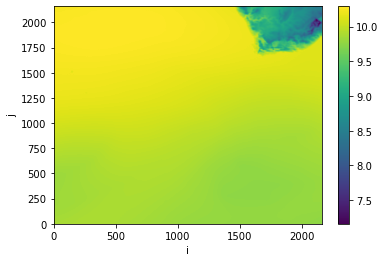

In [85]:
(dr_ij/9.81/1027.5).plot()

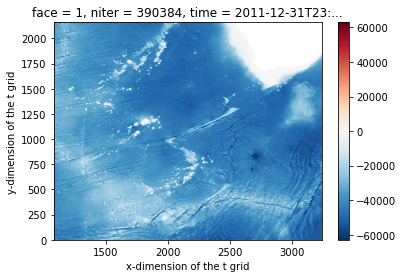

In [89]:
(ds.PhiBot.isel(time=2639)
 -9.81*ds.Depth).isel(face=1,j=slice(0,2160),i=slice(1080,1080+2160)).plot()

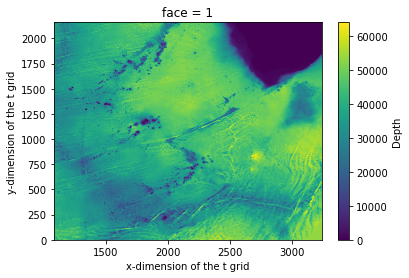

In [91]:
(9.81*ds.Depth.isel(face=1,j=slice(0,2160),i=slice(1080,1080+2160))).plot()

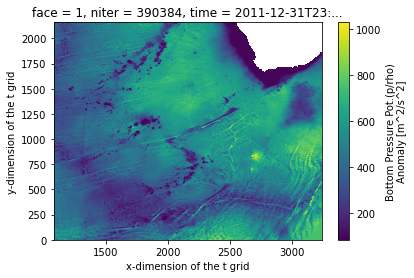

In [76]:
(ds.PhiBot).isel(time=2639).isel(face=1,j=slice(0,2160),i=slice(1080,1080+2160)).plot()

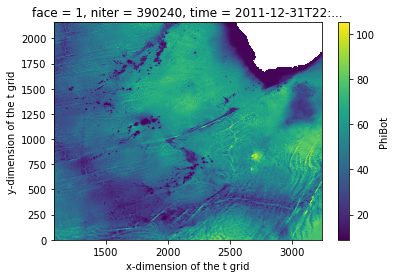

In [88]:
(ds.PhiBot/9.81).isel(time=2638).isel(face=1,j=slice(0,2160)
                                      ,i=slice(1080,1080+2160)).plot()
figure=plt.gcf()
figure.savefig('phibot_over_g.png')

In [81]:
ds.Depth#.isel(face=1,j=slice(0,2160),i=slice(1080,1080+2160)).plot()

<xarray.DataArray 'Depth' (face: 13, j: 4320, i: 4320)>
dask.array<concatenate, shape=(13, 4320, 4320), dtype=float32, chunksize=(3, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    CS       (face, j, i) float32 dask.array<chunksize=(3, 4320, 4320), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(3, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(3, 4320, 4320), meta=np.ndarray>
    dxF      (face, j, i) float32 dask.array<chunksize=(3, 4320, 4320), meta=np.ndarray>
    dyF      (face, j, i) float32 dask.array<chunksize=(3, 4320, 4320), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(3, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(3, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(3, 4320, 4320), meta=np.ndarray>
Attributes:
    standard_name:  ocean_depth
    long_name:      ocean depth
    units:          m
    coordinate:     XC YC

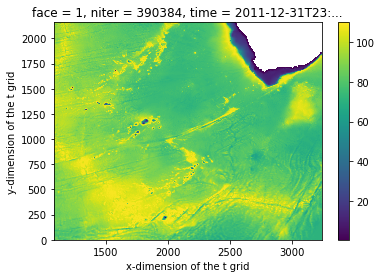

In [78]:
(ds.Depth*9.81/(ds.PhiBot).isel(time=2639)).isel(face=1,j=slice(0,2160),i=slice(1080,1080+2160)).plot()

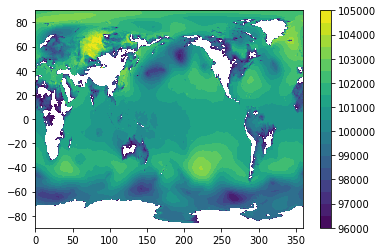

In [43]:
cs = plt.contourf(lon,lat,pres_shaped[0,:,:],levels=np.arange(0.96,1.05,0.005)*10**5)
plt.colorbar(cs)

In [58]:
temp = np.fromfile('/nobackup/dmenemen/forcing/ECMWF_operational/EOG_tmp2m_degC_2012',dtype='>f4')


In [60]:
temp.reshape(-1,1280,2560).shape

(1464, 1280, 2560)

In [30]:
np.zeros((1280, 2560)).shape

(1280, 2560)

In [6]:
fp = np.memmap('/nobackup/dmenemen/forcing/ECMWF_operational/EOG_pres_tide_2011',
               dtype='>f4',mode='r',shape=(8760,1280,2560))

In [ ]:
#find mean atmospheric pressure in this region 2011
counter = 0
atm_slice=np.zeros((1280, 2560))
for t in range(0,8760):
    atm_slice = atm_slice + fp[t*3,:,:]
    if (np.mod(t,100)==0):
        print(t)
    counter=counter+1
mean_pressure = atm_slice/counter

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


IndexError: index 8760 is out of bounds for axis 0 with size 8760

In [9]:
fp = np.memmap('/nobackup/dmenemen/forcing/ECMWF_operational/EOG_pres_tide_2012',
               dtype='>f4',mode='r',shape=(8760,1280,2560))

In [10]:
#find mean atmospheric pressure in this region 2012
for t in range(0,3000):
    atm_slice = atm_slice + fp[t*3,:,:]
    if (np.mod(t,100)==0):
        print(t)
    counter=counter+1
mean_pressure = atm_slice/counter

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


IndexError: index 8760 is out of bounds for axis 0 with size 8760

In [31]:
fp = np.memmap('/nobackup/dmenemen/forcing/ECMWF_operational/EOG_pres_tide_2013',
               dtype='>f4',mode='r',shape=(5826,1280,2560))

In [32]:
#find mean atmospheric pressure in this region 2013
for t in range(0,3000):
    atm_slice = atm_slice + fp[t*3,:,:]
    if (np.mod(t,100)==0):
        print(t)
    counter=counter+1
mean_pressure = atm_slice/counter

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


IndexError: index 5826 is out of bounds for axis 0 with size 5826

In [34]:
mean_pressure = atm_slice/counter

In [43]:
pres_xr = xr.DataArray(mean_pressure, dims=['lat','lon'],coords=dict(lon=lon,lat=lat))

In [44]:
surface_pressure = (pres_xr.roll(lon=200)).sel(lat=slice(-58,-26)).isel(lon=slice(88,455))

/nobackup/csjone15/miniconda3/envs/pangeo-0ac8885/lib/python3.8/site-packages/xarray/core/dataarray.py:3267: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(


In [51]:
surface_pressure_rename = surface_pressure.rename({'lon':'longitude','lat':'latitude'})

In [49]:
ds_out_rename = ds_out.rename({'lon':'longitude','lat':'latitude'})

In [52]:
regridder = xe.Regridder(surface_pressure_rename, ds_out_rename, 'bilinear')

/nobackup/csjone15/miniconda3/envs/pangeo-0ac8885/lib/python3.8/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [53]:
dr_out = regridder(surface_pressure_rename)

/nobackup/csjone15/miniconda3/envs/pangeo-0ac8885/lib/python3.8/site-packages/xesmf/smm.py:129: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [54]:
dr_ij = dr_out.drop_vars(['latitude','longitude']).rename({'latitude':'j','longitude':'i'})

In [58]:
dr_ij.to_dataset(name='pressure').to_zarr('mean_atm_pressure.zarr')

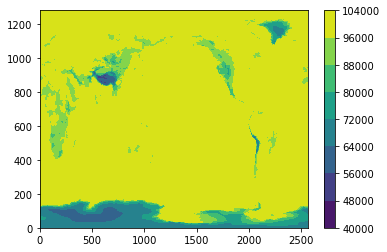

In [37]:
cs = plt.contourf(mean_pressure)
plt.colorbar(cs)

In [3]:
check = np.fromfile('/nobackup/dmenemen/forcing/ECMWF_operational/EOG_pres_tide_2011',dtype='>f4',count=3276800*10,offset = 1343488000)

In [4]:
check.reshape(-1,1280,2560)

array([[[103417.46 , 103421.58 , 103419.67 , ..., 103408.67 ,
         103416.99 , 103413.23 ],
        [103423.734, 103419.875, 103430.99 , ..., 103406.89 ,
         103406.23 , 103414.484],
        [103415.98 , 103423.13 , 103428.27 , ..., 103405.06 ,
         103411.42 , 103413.7  ],
        ...,
        [103609.15 , 103601.89 , 103589.61 , ..., 103621.46 ,
         103617.42 , 103606.8  ],
        [103608.44 , 103593.37 , 103599.445, ..., 103627.35 ,
         103618.5  , 103610.4  ],
        [103608.19 , 103607.98 , 103603.91 , ..., 103619.2  ,
         103617.54 , 103613.96 ]],

       [[103609.91 , 103608.05 , 103600.164, ..., 103621.695,
         103622.72 , 103612.32 ],
        [103618.09 , 103608.26 , 103613.23 , ..., 103622.15 ,
         103614.52 , 103615.82 ],
        [103612.9  , 103613.42 , 103611.75 , ..., 103623.23 ,
         103622.125, 103617.61 ],
        ...,
        [103154.914, 103141.64 , 103124.34 , ..., 103187.38 ,
         103176.29 , 103159.125],
        [103

In [5]:
1280*2560

3276800